In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow_datasets as tfds
import keras

### Start with loading the dataset

In [39]:
batch_size = 10
img_height = 288
img_width = 432

#images original being a directory of the dataset, each subdirectory of images_original is a class folder
#each class folder contains samples belonging to that class
data_dir = './images_original'

#since spectrograms contain no meaningful RGB information grayscaling doesnt have any information loss
train = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = 'grayscale',
  label_mode = 'categorical')

val = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = 'grayscale',
  label_mode = 'categorical')


Found 999 files belonging to 10 classes.
Using 800 files for training.
Found 999 files belonging to 10 classes.
Using 199 files for validation.


### Defining the model architecture

In [40]:
num_classes = 10

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [41]:
model.compile(optimizer='adam',
                          loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                          metrics=['accuracy'])

In [110]:
import os

EPOCHS = 5

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(
  train,
  validation_data = val,
  epochs=EPOCHS,
  callbacks=[cp_callback]
)
model.summary()

Epoch 1/5
80/80 [==============================] - ETA: 0s - loss: 0.3029 - accuracy: 0.9112
Epoch 1: saving model to training_1\cp.ckpt
80/80 [==============================] - 85s 1s/step - loss: 0.3029 - accuracy: 0.9112 - val_loss: 1.3714 - val_accuracy: 0.5528
Epoch 2/5
80/80 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9800
Epoch 2: saving model to training_1\cp.ckpt
80/80 [==============================] - 86s 1s/step - loss: 0.0862 - accuracy: 0.9800 - val_loss: 1.4866 - val_accuracy: 0.5729
Epoch 3/5
80/80 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9875
Epoch 3: saving model to training_1\cp.ckpt
80/80 [==============================] - 95s 1s/step - loss: 0.0441 - accuracy: 0.9875 - val_loss: 2.1065 - val_accuracy: 0.5226
Epoch 4/5
80/80 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 0.9862
Epoch 4: saving model to training_1\cp.ckpt
80/80 [==============================] - 100s 1s/step - loss: 0.0

In [111]:
results = model.evaluate(val, batch_size=128)

20/20 [==============================] - 5s 215ms/step - loss: 2.0308 - accuracy: 0.5779


1/1 [==============================] - 0s 130ms/step
This image most likely belongs to hiphop with a 97.52 percent confidence.
(it is actually hiphop)


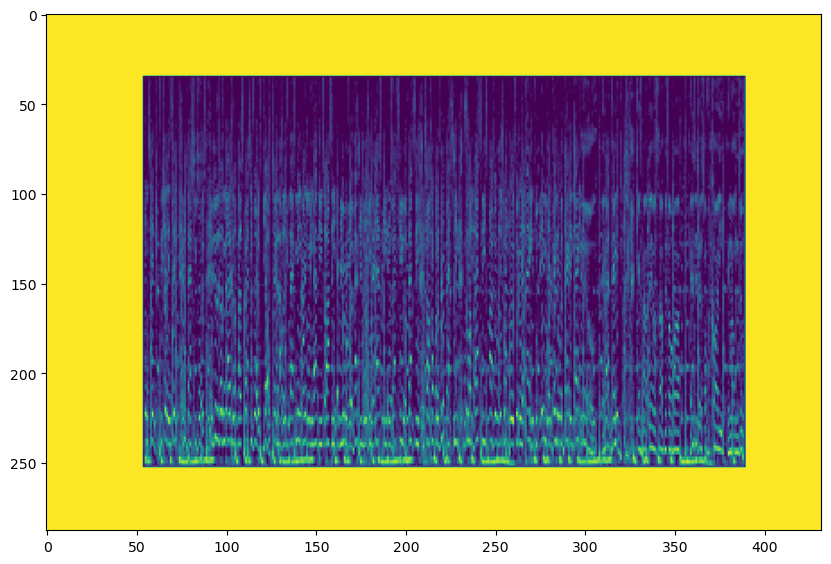

In [138]:
plt.figure(figsize=(10, 10))
class_names = train.class_names

t = val.take(1)

for image, label in t:
    i = 0
    
    img = image[i]
    plt.imshow(image[i].numpy().astype("uint8"))
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    #print(predictions)
    #print(label[i])
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predictions)], 100 * np.max(predictions))
    )
    
    print("(it is actually {})".format(class_names[np.argmax(label[i])]))

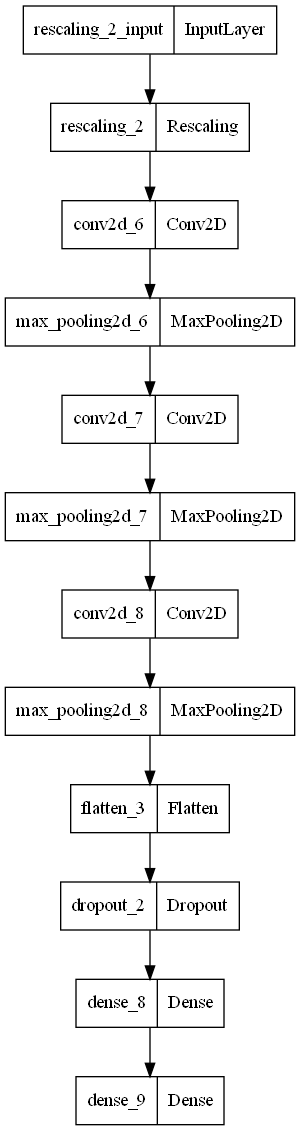

In [119]:
#visualize architecture
keras.utils.plot_model(model, "cnn_from_scratch.png")

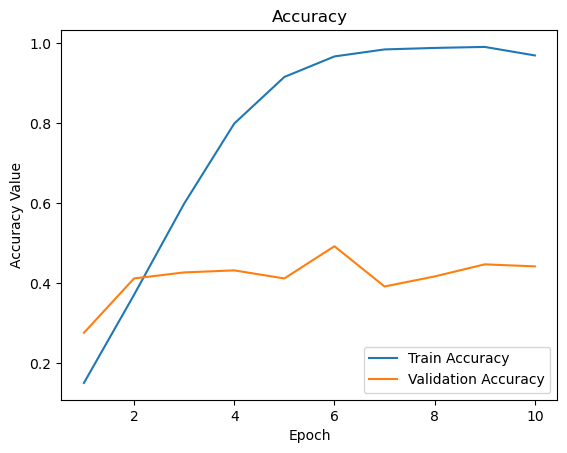

In [12]:
import matplotlib.pyplot as plt
import numpy as np

history = fitted 
#change the earlier line that says model.fit(blah blah blah) to fitted = model.fit(blah blah blah)

epoch_list = list(range(1,len(history.history['accuracy'])+1))
plt.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
plt.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend(loc="lower right")

In [21]:
results = model.evaluate(val, batch_size=128)

20/20 [==============================] - 4s 176ms/step - loss: 1.8390 - accuracy: 0.5578


### Transfer Learning---using VGGish

In [14]:
from vggish import VGGish

import vggish_params as params

WEIGHTS_PATH = "vggish_audioset_weights_without_fc2.h5"
#you will have to download the pretrained model manually
#it was too big for the github
EPOCHS = 20

base_model = VGGish(include_top=False)

base_model.trainable = False

last_layer = base_model.output
x = tf.keras.layers.Flatten()(last_layer)
x = tf.keras.layers.Dense(units = 256, activation = 'relu')(x)
x = tf.keras.layers.Dense(units = 256, activation = 'relu')(x)
x = tf.keras.layers.Dense(units = 128, activation = 'relu')(x)
x = tf.keras.layers.Dense(units = 10, activation = 'softmax')(x)

pre_trained_model = tf.keras.Model(inputs = base_model.inputs, outputs = x)

pre_trained_model.compile(optimizer='adam',
                          loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                          metrics=['accuracy'])

In [15]:
EPOCHS = 160

checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

fitted_pre_trained = pre_trained_model.fit(train, 
                                           validation_data = val, 
                                           epochs = EPOCHS,
                                           callbacks=[cp_callback2])

Epoch 1/160


KeyboardInterrupt: 

In [16]:
history = fitted_pre_trained 
#change the earlier line that says model.fit(blah blah blah) to fitted = model.fit(blah blah blah)

epoch_list = list(range(1,len(history.history['accuracy'])+1))
plt.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
plt.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend(loc="lower right")

NameError: name 'fitted_pre_trained' is not defined

In [ ]:
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

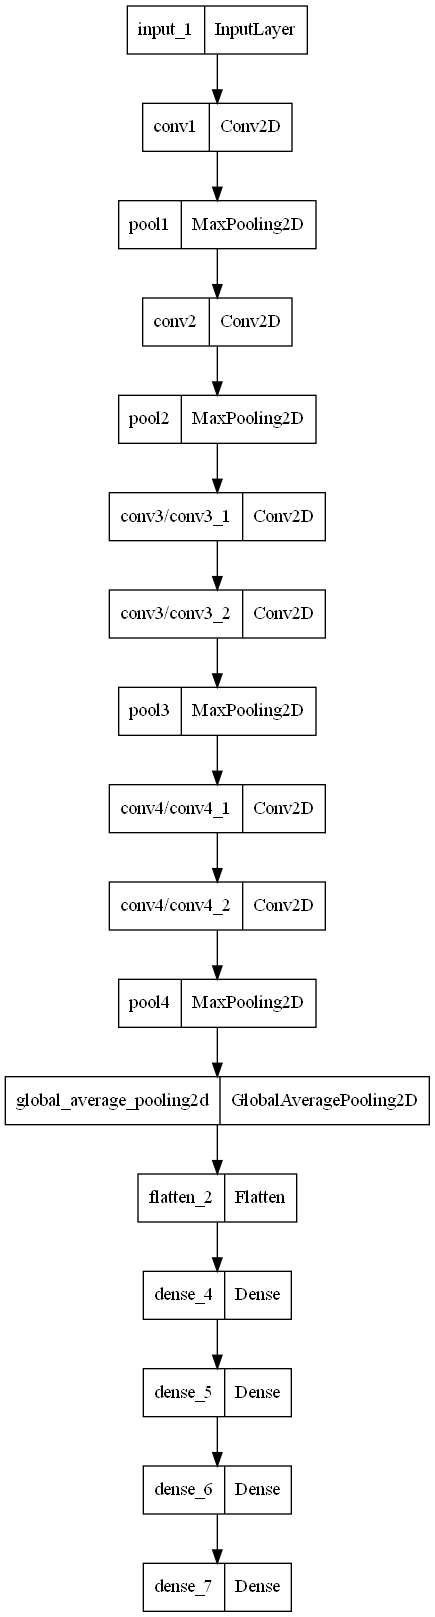

In [17]:
keras.utils.plot_model(pre_trained_model, "pre_trained.png")

In [25]:
pre_trained_model.layers

In [9]:
for layer in pre_trained_model.layers:
    print("weights:", len(layer.weights))
    print("trainable_weights:", len(layer.trainable_weights))
    print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 0
trainable_weights: 0
non_trainable_weights: 0
weights: 2
trainable_weights: 0
non_trainable_weights: 2
weights: 0
trainable_weights: 0
non_trainable_weights: 0
weights: 2
trainable_weights: 0
non_trainable_weights: 2
weights: 0
trainable_weights: 0
non_trainable_weights: 0
weights: 2
trainable_weights: 0
non_trainable_weights: 2
weights: 2
trainable_weights: 0
non_trainable_weights: 2
weights: 0
trainable_weights: 0
non_trainable_weights: 0
weights: 2
trainable_weights: 0
non_trainable_weights: 2
weights: 2
trainable_weights: 0
non_trainable_weights: 2
weights: 0
trainable_weights: 0
non_trainable_weights: 0
weights: 0
trainable_weights: 0
non_trainable_weights: 0
weights: 0
trainable_weights: 0
non_trainable_weights: 0
weights: 2
trainable_weights: 2
non_trainable_weights: 0
